Mushi
==
_All that the rain promises and more..._

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

API documentation can be viewed with
```python
help(mushi.η)
help(mushi.𝜇)
help(mushi.kSFS)
```

In [1]:
%matplotlib inline 
# %matplotlib notebook
import mushi
import histories
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time
import msprime
%cd stdpopsim
from stdpopsim import homo_sapiens
%cd ../

/home/kameron/work/mushi/stdpopsim
/home/kameron/work/mushi


In [2]:
# plt.style.use('dark_background')

### Time grid

In [3]:
t = np.logspace(0, np.log10(3e4), 100)

### Demographic history $\eta(t)$ from the European population in Tennessen et al.

In [4]:
model = homo_sapiens.TennessenTwoPopOutOfAfrica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η_Tennessen = histories.η(t, y)

### Demographic history $\eta(t)$ from the European population in Browning et al.

In [5]:
model = homo_sapiens.BrowningAmerica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η_Browning = histories.η(t, y)

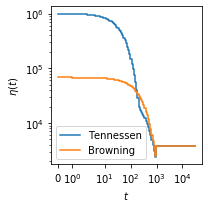

In [6]:
plt.figure(figsize=(3, 3))
η_Tennessen.plot(label='Tennessen')
η_Browning.plot(label='Browning')
plt.show()

### Mutation rate history $\mu(t)$
A 96 dimensional history with a mixture of two latent signature: constant and pulse.

In [7]:
tt = np.concatenate(([0], t))
flat = np.ones_like(tt)
pulse = expit(.01 * (tt - 100)) - expit(.01 * (tt - 1000))
cols = 96
Z = np.zeros((len(t) + 1, cols))
μ0 = 1
np.random.seed(0)
pulse_idxs = []
flat_idxs = []
for col in range(cols):
    scale = np.random.lognormal(0, 0.2)
    pulse_weight = np.random.lognormal(-0.5, .5) if col < 5 else 0
    Z[:, col] = μ0 * (scale * (flat + pulse_weight * pulse))
    if pulse_weight:
        pulse_idxs.append(col + 1)
    else:
        flat_idxs.append(col + 1)
        
μ = histories.μ(t, Z)

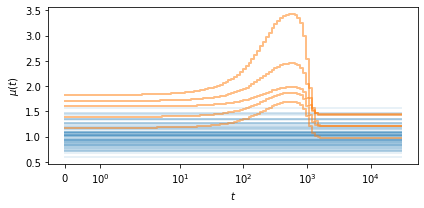

In [8]:
plt.figure(figsize=(6, 3))
μ.plot(flat_idxs, alpha=0.1, lw=2, c='C0', normed=False)
μ.plot(pulse_idxs, alpha=0.5, lw=2, c='C1', normed=False)
plt.show()

In [9]:
μ_0 = μ.Z.sum(1).mean()

## Simulate a $k$-SFS under this history using Tennessen demography
- We'll sample 198 haplotypes
- We can simulate $\eta(t)$ misspecification by simulating from Tennessen, but inferring with Browning

/home/kameron/local/anaconda3/envs/mushi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


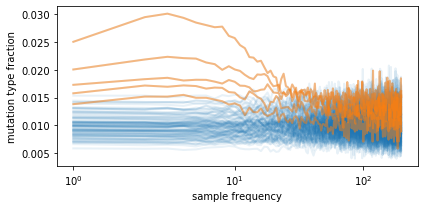

In [10]:
n = 198
# η_flat = histories.η(t, 1000 * np.ones(len(t) + 1))
# ksfs_flat = mushi.kSFS(η=η_flat, μ=μ, n=n)
# ksfs_flat.simulate(seed=1)
ksfs_Tennessen = mushi.kSFS(η=η_Tennessen, μ=μ, n=n)
ksfs_Tennessen.simulate(seed=1)

ksfs = mushi.kSFS(X=ksfs_Tennessen.X)
# # flat
# ksfs = mushi.kSFS(X=ksfs_flat.X)

plt.figure(figsize=(6, 3))
ksfs.plot(alpha=0.1, lw=2, c='C0', normed=True)
for idx in pulse_idxs:
    ksfs.plot(idx, alpha=0.5, lw=2, c='C1', normed=True)
plt.show()

### TMRCA CDF

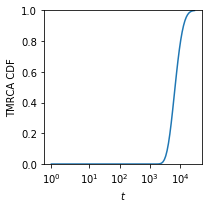

In [11]:
plt.figure(figsize=(3, 3))
plt.plot(μ.change_points, ksfs_Tennessen.tmrca_cdf())
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Initialize by fitting constant $\eta(t)$ and $\mu(t)$

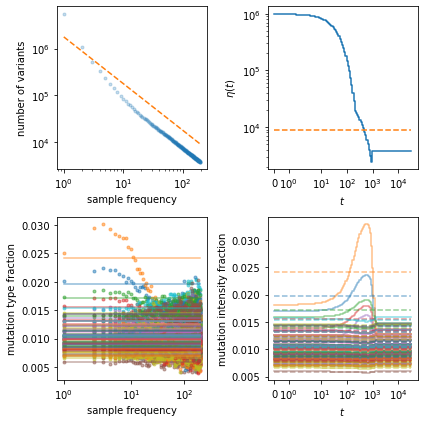

In [12]:
mask = np.array([False if (0 <= i <= n - 20) else True for i in range(n - 1)])

ksfs.infer_constant(change_points=t, μ_0=μ_0, mask=mask)

plt.figure(figsize=(6, 6))
plt.subplot(221)
ksfs.plot_total()
plt.subplot(222)
η_Tennessen.plot()
ksfs.η.plot(ls='--')
plt.subplot(223)
ksfs.plot(normed=True, alpha=0.5)
plt.subplot(224)
μ.plot(normed=True, alpha=0.5)
plt.gca().set_prop_cycle(None)
ksfs.μ.plot(normed=True, ls='--', alpha=0.5)
plt.show()

### Infer $\eta(t)$ and $\boldsymbol\mu(t)$

block coordinate descent sweep 1
η block
relative change in objective function 7.5e-08 is within tolerance 1.0000000000000001e-07 after 3 iterations
μ block
relative change in objective function 3.7e-08 is within tolerance 1e-05 after 1 iterations
cost: -85492210.35509916



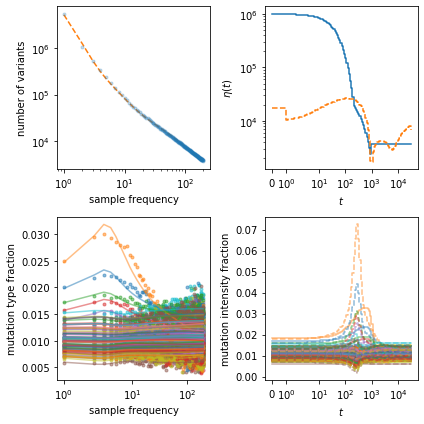

block coordinate descent sweep 2
η block
relative change in objective function 9.1e-08 is within tolerance 1.0000000000000001e-07 after 3 iterations
μ block
relative change in objective function 1.2e-06 is within tolerance 1e-05 after 1 iterations
cost: -85492130.64322004
relative change: 9.3e-07



In [ ]:
f_trajectory = []

sweeps = 20
for sweep in range(1, 1 + sweeps):    
    print(f'block coordinate descent sweep {sweep:.2g}')
    f = ksfs.coord_desc(# loss function parameters
                        fit='prf',
                        mask=mask,
                        # η(t) regularization parameters
                        α_tv=0,#1e3,
                        α_spline=1e2,
                        # μ(t) regularization parameters
                        β_tv=0,
                        β_spline=1e3,   
                        # spectral regularization parameters
                        β_rank=0,#5e3,
                        β_ridge=1e-6,
                        hard=True,                                     
                        # convergence parameters
                        max_iter=10000,
                        tol=1e-5,
                        γ=0.5)
    print(f'cost: {f}')
    if sweep > 1:
        relative_change = np.abs((f - f_old) / f_old)
        print(f'relative change: {relative_change:.2g}')
    print()
    f_old = f
    f_trajectory.append(f)
        
    plt.figure(figsize=(6, 6))
    plt.subplot(221)
    ksfs.plot_total()
    plt.subplot(222)
    η_Tennessen.plot()
    ksfs.η.plot(ls='--')
    plt.subplot(223)
    ksfs.plot(normed=True, alpha=0.5)
    plt.subplot(224)
    μ.plot(normed=True, alpha=0.5)
    plt.gca().set_prop_cycle(None)
    ksfs.μ.plot(normed=True, ls='--', alpha=0.5)
    plt.show()


plt.figure(figsize=(4, 2))
plt.plot(f_trajectory)
plt.xlabel('iterations')
plt.ylabel('cost')
# plt.xscale('symlog')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 2.5))
plt.subplot(121)
ksfs.plot(alpha=0.02, c='k', lw=1, normed=True)
for color_idx, mut_type in enumerate(pulse_idxs):
    ksfs.plot(mut_type, lw=2, c=f'C{color_idx}', normed=True, label=mut_type)
plt.legend().remove()#loc=2, prop={'size': 7.5})
plt.xlim([2, None])
plt.subplot(122)
μ.plot(flat_idxs, ls='dotted', alpha=0.1, lw=1, c='k', normed=True)
ksfs.μ.plot(flat_idxs, alpha=0.1, lw=1, c='k', normed=True)
for color_idx, mut_type in enumerate(pulse_idxs):
    μ.plot(types=[mut_type], lw=2, normed=True, label=mut_type, c=f'C{color_idx}', ls='dotted')
    ksfs.μ.plot(types=[mut_type], lw=2, normed=True, label=mut_type, c=f'C{color_idx}')
plt.legend().remove()#loc=2, prop={'size': 7.5})

# plt.savefig('/Users/williamdewitt/Downloads/sim.pdf', transparent=True)
plt.show()

# plt.savefig('/Users/williamdewitt/Downloads/1KG.pdf', transparent=True)
plt.show()

Data and forward reconstruction

plot $\chi^2$ goodness of fit for each $k$-SFS matrix element, and compute $\chi^2$ goodness of fit test for the $k$-SFS matrix as a whole

In [ ]:
ksfs.clustermap(ksfs.μ, figsize=(10, 5), cmap='Reds')
plt.show()

### Singular value spectrum of $Z$

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(range(min(ksfs.μ.Z.shape)), np.linalg.svd(Z, compute_uv=False), '.')
plt.yscale('log')
plt.tight_layout()
plt.show()